In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output

from audio_stream import record

import tensorflow as tf
import tensorflow_io as tfio

from pynput.keyboard import Key, Controller

In [2]:
def get_spectrogram(waveform, type=False):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    waveform = tf.cast(waveform, tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    stfts = tf.signal.stft(equal_length, frame_length=255, frame_step=128, fft_length=256)

    spectrograms = tf.abs(stfts)
    
    if not type:
        return spectrograms

    batch_size, num_samples, sample_rate = 32, 16000, 16000.0

    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 13
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)

    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    if type == 'mel': 
        return tf.abs(mel_spectrograms)
    
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    
    if type == 'log_mel':
        return tf.abs(log_mel_spectrograms)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)

    return tf.abs(mfccs)

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)

    # Fade out
    audio = tfio.audio.fade(audio, fade_in=1000, fade_out=1000, mode="logarithmic") 
    return audio

def get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform

def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')

In [3]:
model = tf.keras.models.load_model('models/geo_augmented_1')

commands = np.array(['ზევით', 'უკან', 'მარცხნივ', 'ქვევით', 'მარჯვნივ', 'წინ'])

In [4]:
def keypress(key):
    keyboard = Controller()
    keyboard.press(key)
    keyboard.release(key)

In [5]:
def predict(file_dir=False): 
    clear_output()
    
    audio_binary = tf.io.read_file(file_dir)
    waveform = decode_audio(audio_binary)
    
    pure_spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(pure_spectrogram, -1)
    spectrogram = spectrogram[None, :, :, :]
    
    prediction = model.predict(spectrogram)
    pred = tf.Variable(tf.nn.softmax(prediction)).numpy().tolist()[0]
    index = pred.index(max(pred))
    keyword = commands[index]
    
    if keyword == 'მარცხნივ':
        keypress(Key.left)
    elif keyword == 'მარჯვნივ':
        keypress(Key.right)
    elif keyword == 'ქვევით':
        keypress(Key.down)
    elif keyword == 'ზევით':
        keypress(Key.up)
    elif keyword == 'წინ':
        keypress(Key.enter)
    elif keyword == 'უკან':
        keypress(Key.backspace)

    plt.figure(figsize=(8, 2))
    plot_spectrogram(pure_spectrogram.numpy(), plt.subplot(1, 2, 2))
    plt.axis('off')

    plt.subplot(1, 2, 1)
    timescale = np.arange(waveform.shape[0])
    plt.plot(timescale, waveform.numpy())
    plt.ylim(-0.7, 0.7)
    plt.axis('off')
    plt.show()
     
    plt.figure(figsize=(8, 4))
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.show()
    


<ipython-input-2-24da6ba5dd9f>:53: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


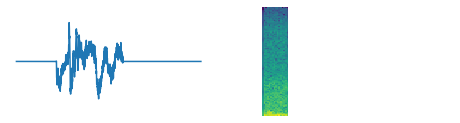

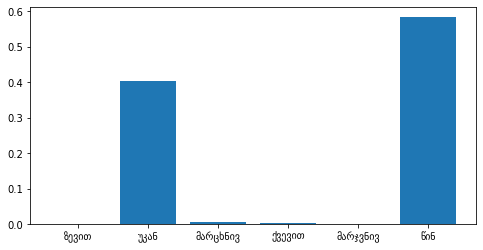

In [6]:
record(predict, False) # live prediction
# predict('data/record_data/test/1.wav') # Predict from file